### Carbon Sequestration Optimal Control Problem

Solves the problem

\begin{align*}
    \max_{s(\cdot)} \quad &\int_0^T e^{-\rho t} \Big( p_C \, C(t) \, \omega + (\kappa) \big(1 + \gamma (1-\frac{(C(t)-\hat{C})^2}{(\hat{C} - \sigma C_0)^2}) \big) - s(t) \, \theta \, \big(\bar{C} - C(t)\big)^{-\epsilon} - 1_{s(t)>0} FC \Big) \, dt \\
    \textrm{s.t.} \quad C'(t) &= s(t)^{\alpha} - \delta C(t), \\
    C(0) &= 0, \\ 
    0 \leq C(t) &\leq \bar{C} - 10^{-3} \\
    0 \leq s(t) &\leq 1000,  \\
\end{align*}

Below is the justification for the following restrictions:

\begin{align*}
    0 \leq C(t) &\leq \bar{C} - 10^{-3} & \textrm{(avoids negative SOC + avoids unbounded SOC accumulation)}
\end{align*}

\begin{align*}
    0 \leq s(t) &\leq 1000 & \textrm{(avoids negative investment)}
\end{align*}

In [1]:
# import idaes # comment out if you did not install idaes with Pyomo

import pyomo.environ as pyo
import pyomo.dae as dae

from matplotlib import rc, rcParams
rcParams['font.size'] = 16
rc('font', family='sans-serif')
rcParams['font.family'] = 'Serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Default values of parameters - do not touch
rho = 0.05
delta = 0.01 # MRT of 100 years

# theta = 19455 and eta = 0.95 determine a minimum cost of intensive investment of $214.66 per Mg of carbon at 0 Mg/ha
theta = 19455 
eta = 0.95
kappa = 247 # net income per hectare
p_C = 27.74 # annuity payment per Mg of carbon of 150 dollar per offset
FC = 14.25 # fixed cost of carbon investment

C0 = 35.78
sigma = 0.354
gamma = 0.26 # net productivity gain of SOC
hat_C = 78 # organic carbon level resulting peak productivity gain
alpha = 0.93
epsilon = 1e-6

omega = 1
overline_C = 115

In [3]:
# duration
T = 100

C_LMP = C0 * sigma

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C_LMP)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C_LMP)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,        # Increase maximum iterations
}
results = solver.solve(M, tee=True)

# Extract results
t_opt = [pyo.value(t) for t in M.t]
C_opt = [pyo.value(M.C[t]) for t in M.t]
s_opt = [pyo.value(M.s[t]) for t in M.t]
Z_opt = [pyo.value(M.Z[t]) for t in M.t]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

In [4]:
# plot results
t_opt = [t for t in M.t]

C_opt_full_monetization = [M.C[t]() for t in M.t]
Z_opt = [M.Z[t]() for t in M.t]
s_opt = [M.s[t]() for t in M.t if t != 0]

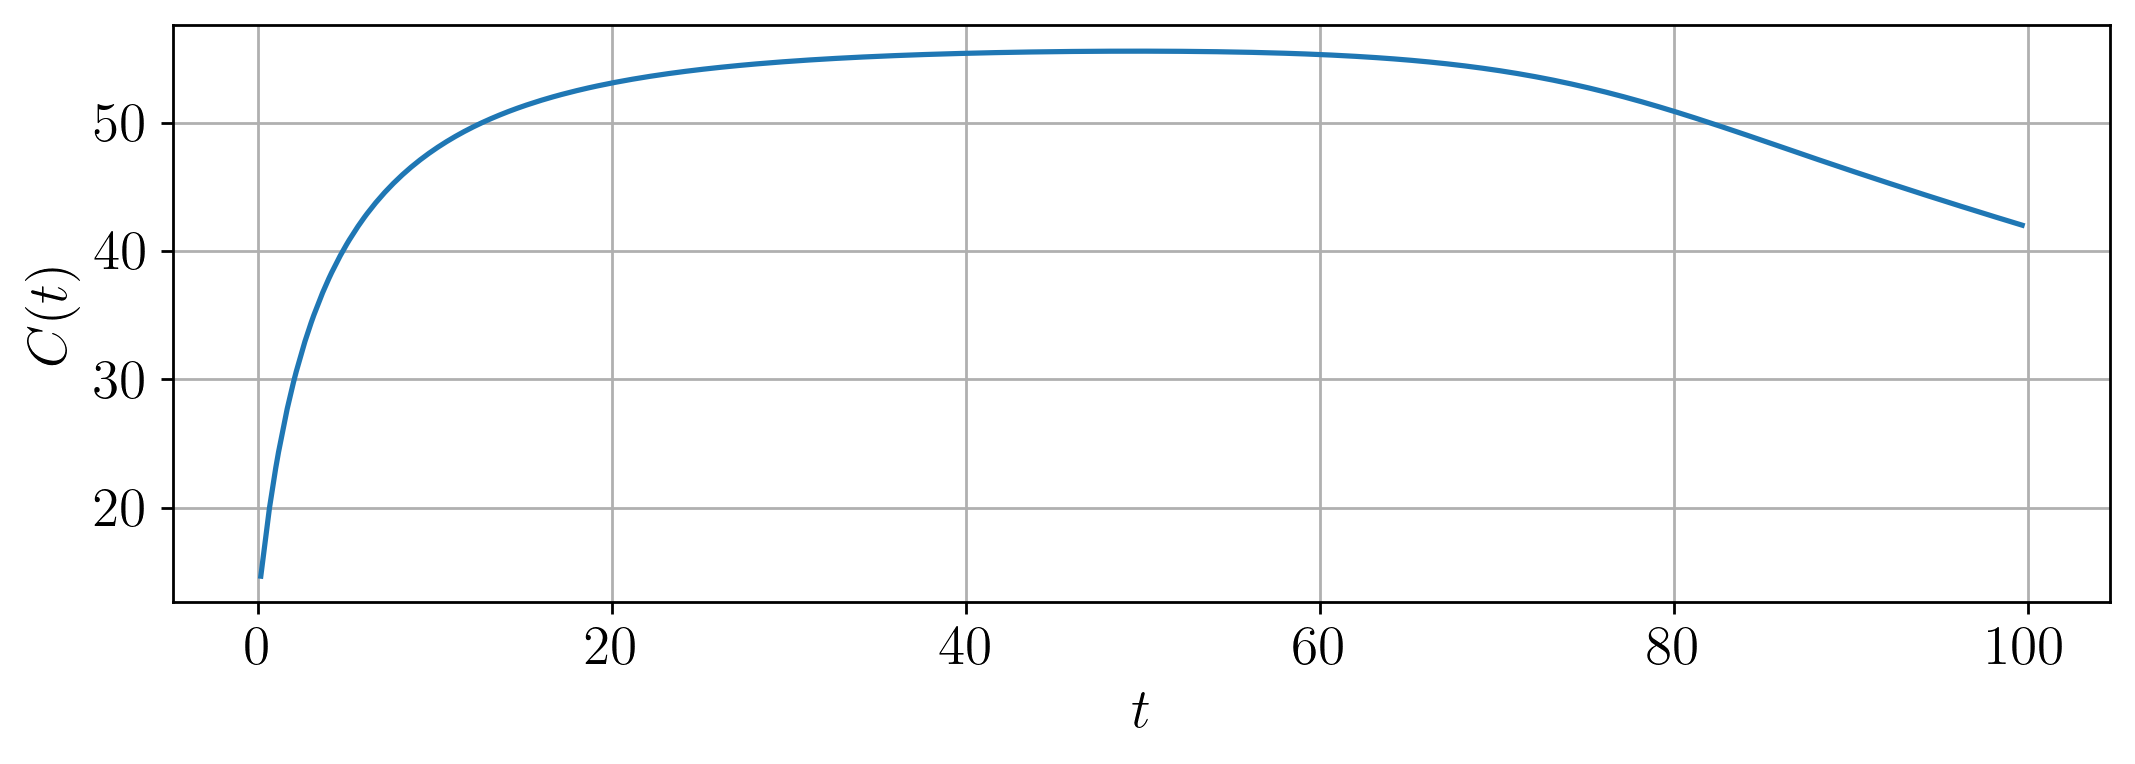

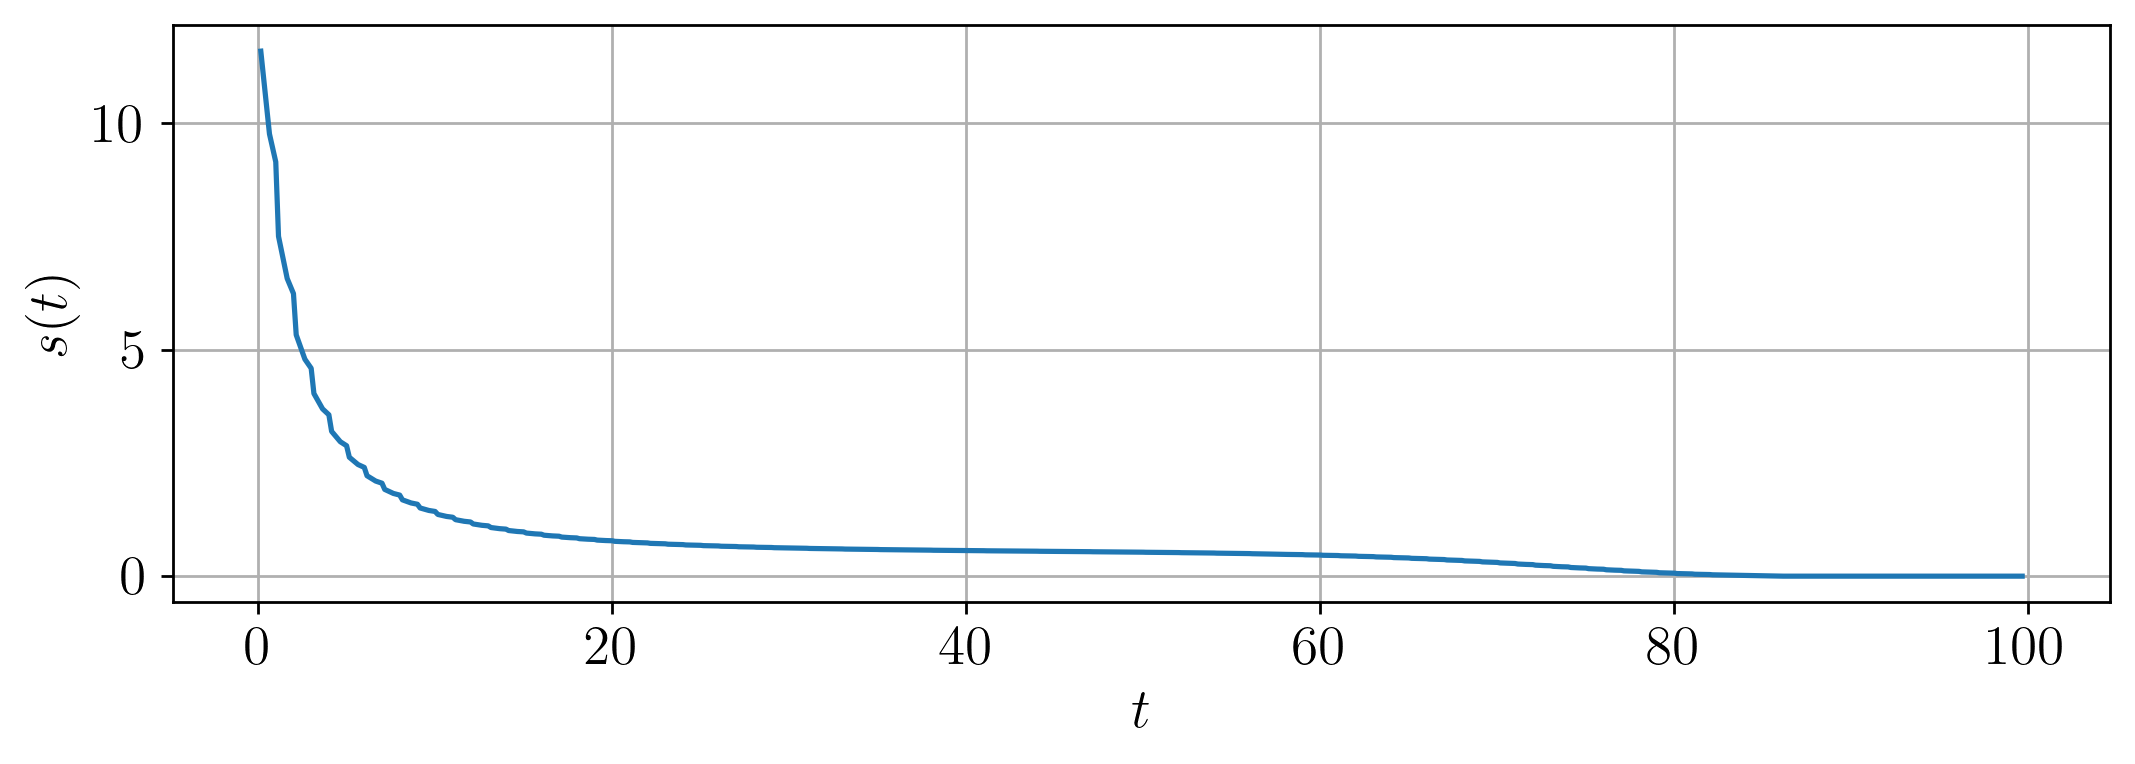

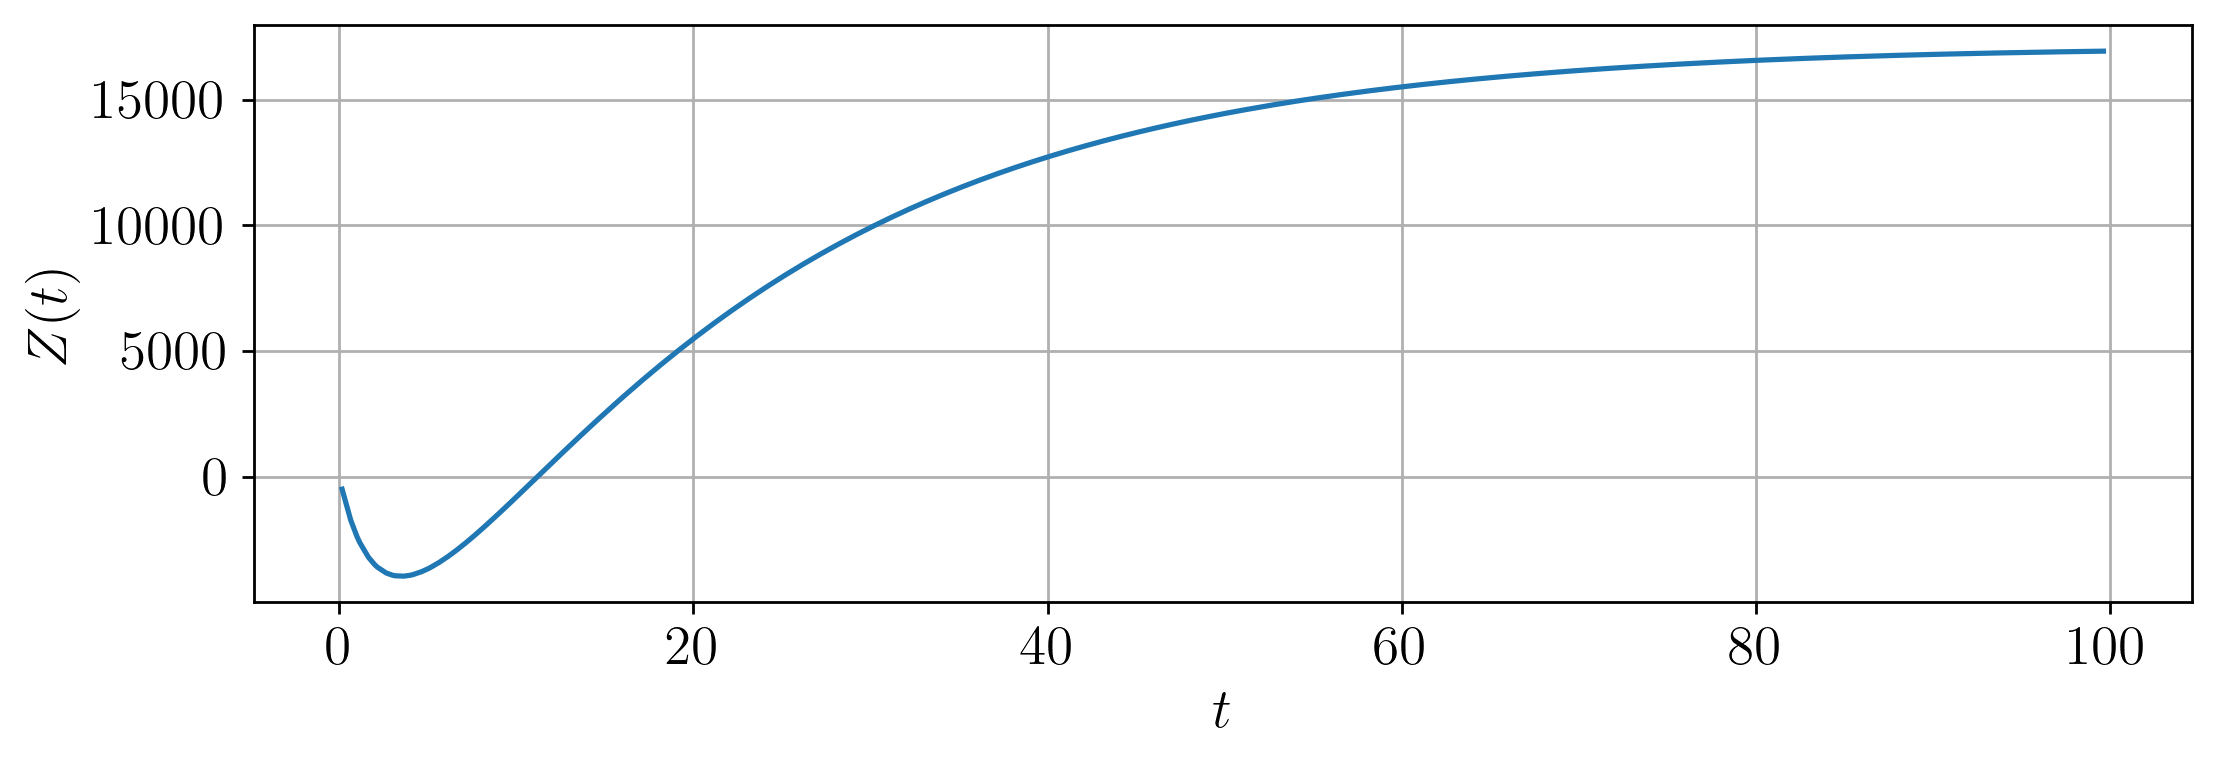

In [5]:
plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:300], C_opt_full_monetization[1:300])
plt.xlabel(r"$t$")
plt.ylabel(r"$C(t)$")
plt.grid(True)

plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:300], s_opt[1:300])
plt.xlabel(r"$t$")
plt.ylabel(r"$s(t)$")
plt.grid(True)

plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:300], Z_opt[1:300])
plt.xlabel(r"$t$")
plt.ylabel(r"$Z(t)$")
plt.grid(True)

In [6]:
def price_threshold(C, alpha, chi, theta, overline_C, eta, rho, delta, omega,
                    kappa, gamma, hat_C, sigma, C0):
    # Variable application cost term
    a_C = theta * (overline_C - C)**(-eta)

    # Shadow-value threshold for switching
    lambda_on = (1 / alpha) * ((alpha * chi) / (1 - alpha))**(1 - alpha) * a_C**alpha

    # Curvature term from crop profit
    curvature_term = ((2 * kappa * gamma) / omega) * ((C - hat_C) / (hat_C - (sigma * C0))**2)

    # Breakeven price
    p_C_star = ((rho + delta) / omega) * lambda_on + curvature_term
    return p_C_star


# Example usage:
p_star = price_threshold(
    C_LMP, alpha, FC, theta, overline_C, eta, rho, delta, omega,
    kappa, gamma, hat_C, sigma, C0
)
print(f"Breakeven price p_C^* = {p_star:.4f}")

Breakeven price p_C^* = 13.2402


### Comparison picture - Full monetization vs Additionality

In [7]:
omega = 0.05

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C- C_LMP)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C_LMP)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# Extract results
t_opt = [pyo.value(t) for t in M.t]
C_opt = [pyo.value(M.C[t]) for t in M.t]
s_opt = [pyo.value(M.s[t]) for t in M.t]
Z_opt_additionality = [pyo.value(M.Z[t]) for t in M.t]

# compute results
C_opt_additionality = [M.C[t]() for t in M.t]
s_opt_additionality = [M.s[t]() for t in M.t]

C_diff = [x - y for x, y in zip(C_opt_full_monetization, C_opt_additionality)]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

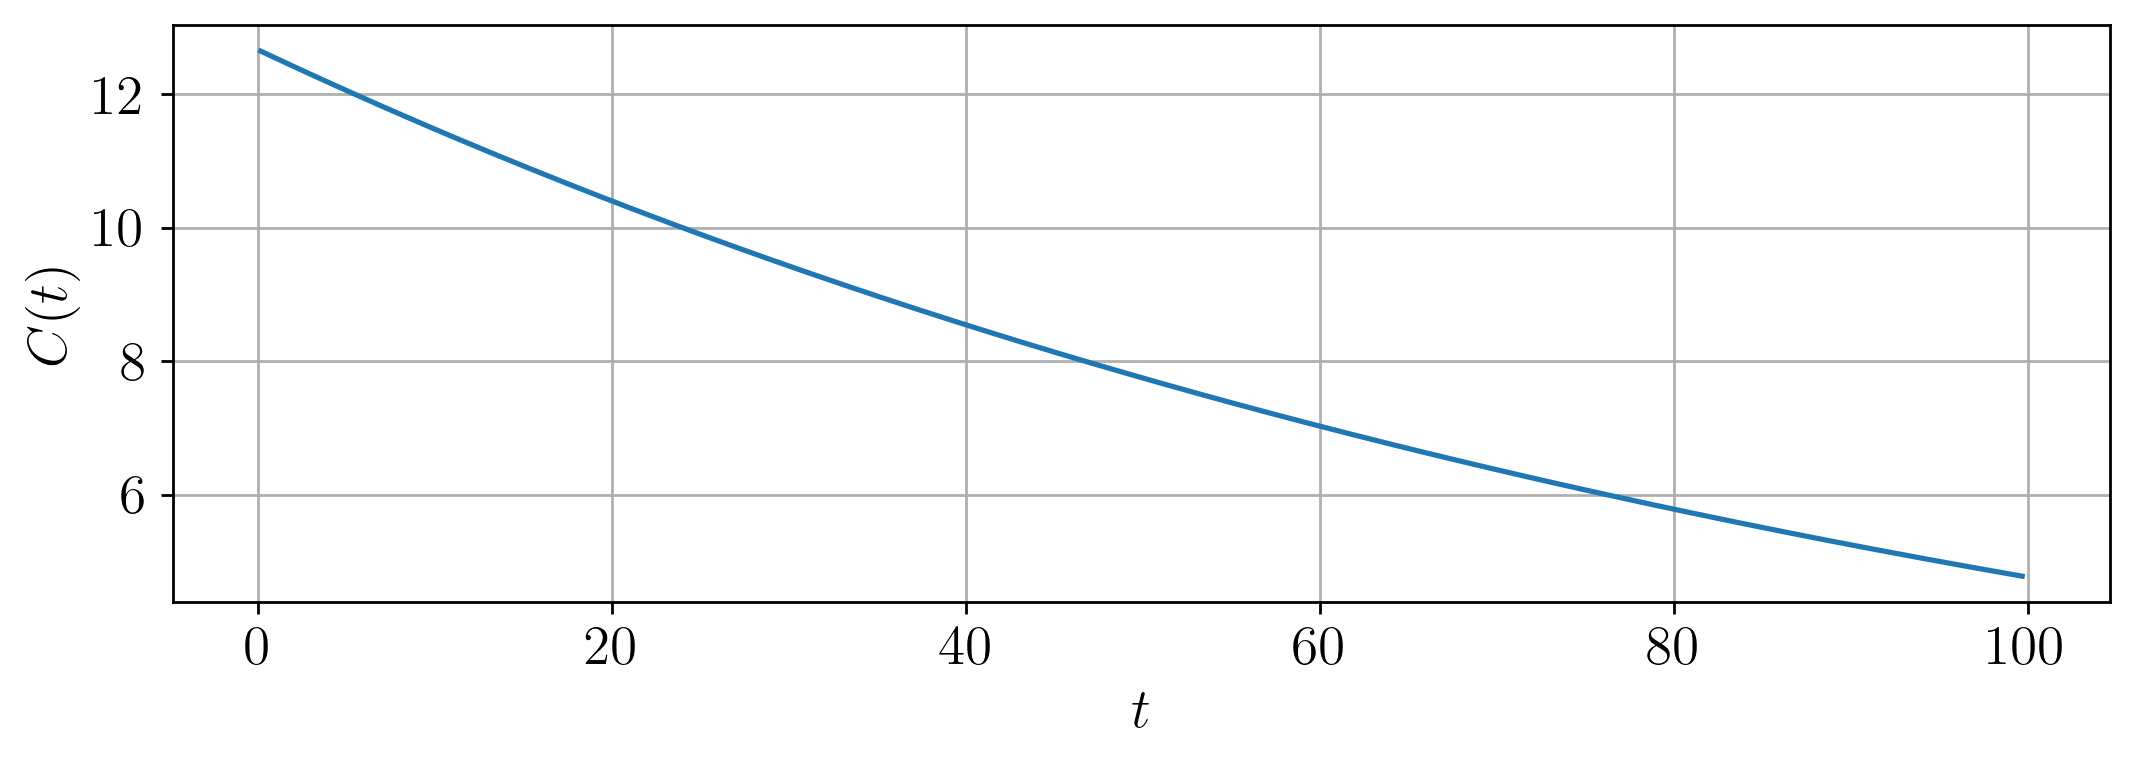

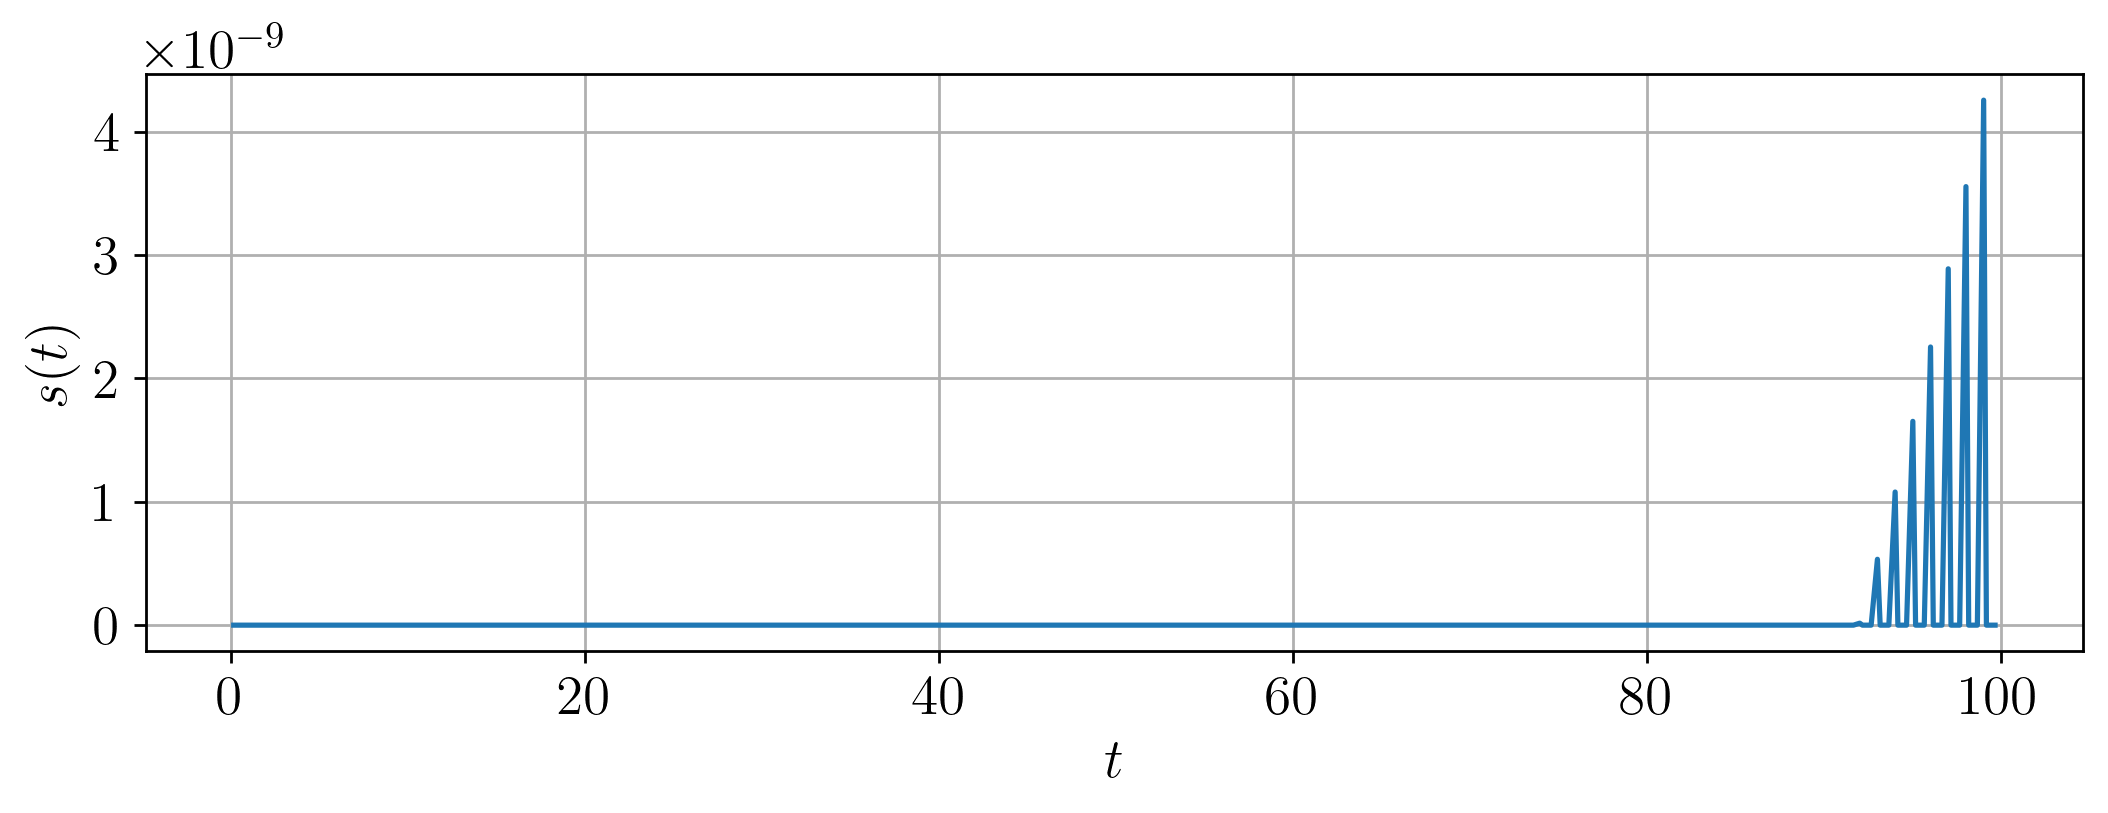

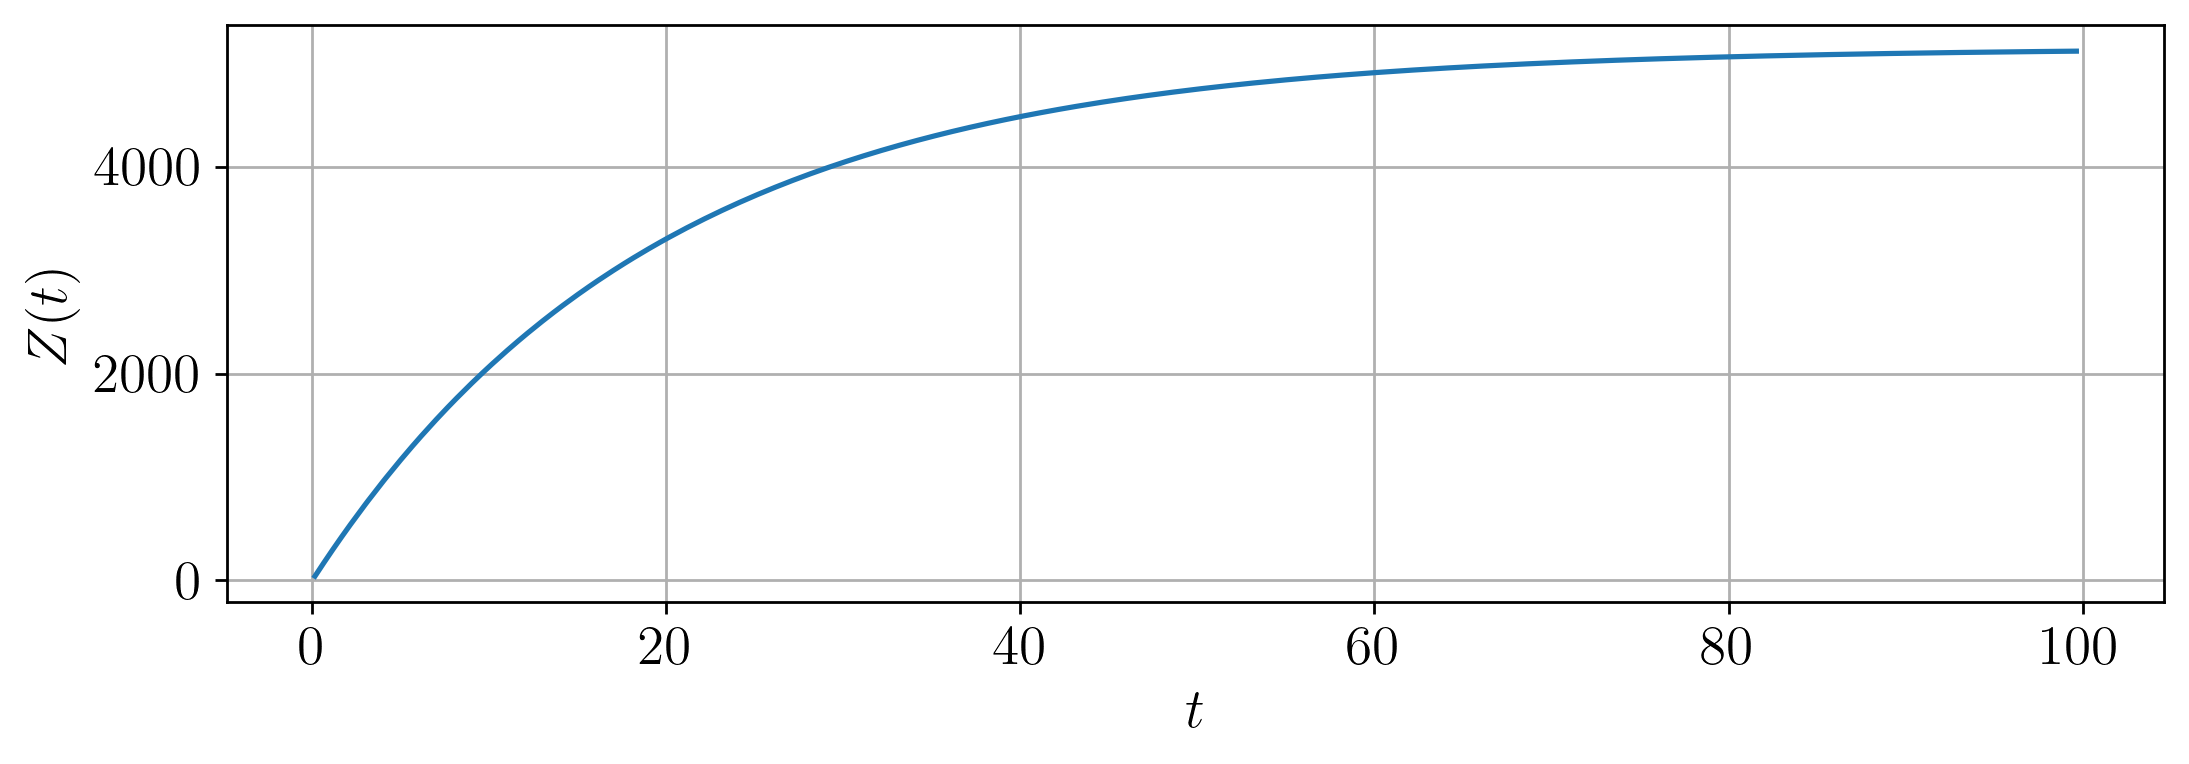

In [8]:
plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:300], C_opt_additionality[1:300])
plt.xlabel(r"$t$")
plt.ylabel(r"$C(t)$")
plt.grid(True)

plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:300], s_opt_additionality[1:300])
plt.xlabel(r"$t$")
plt.ylabel(r"$s(t)$")
plt.grid(True)

plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:300], Z_opt_additionality[1:300])
plt.xlabel(r"$t$")
plt.ylabel(r"$Z(t)$")
plt.grid(True)

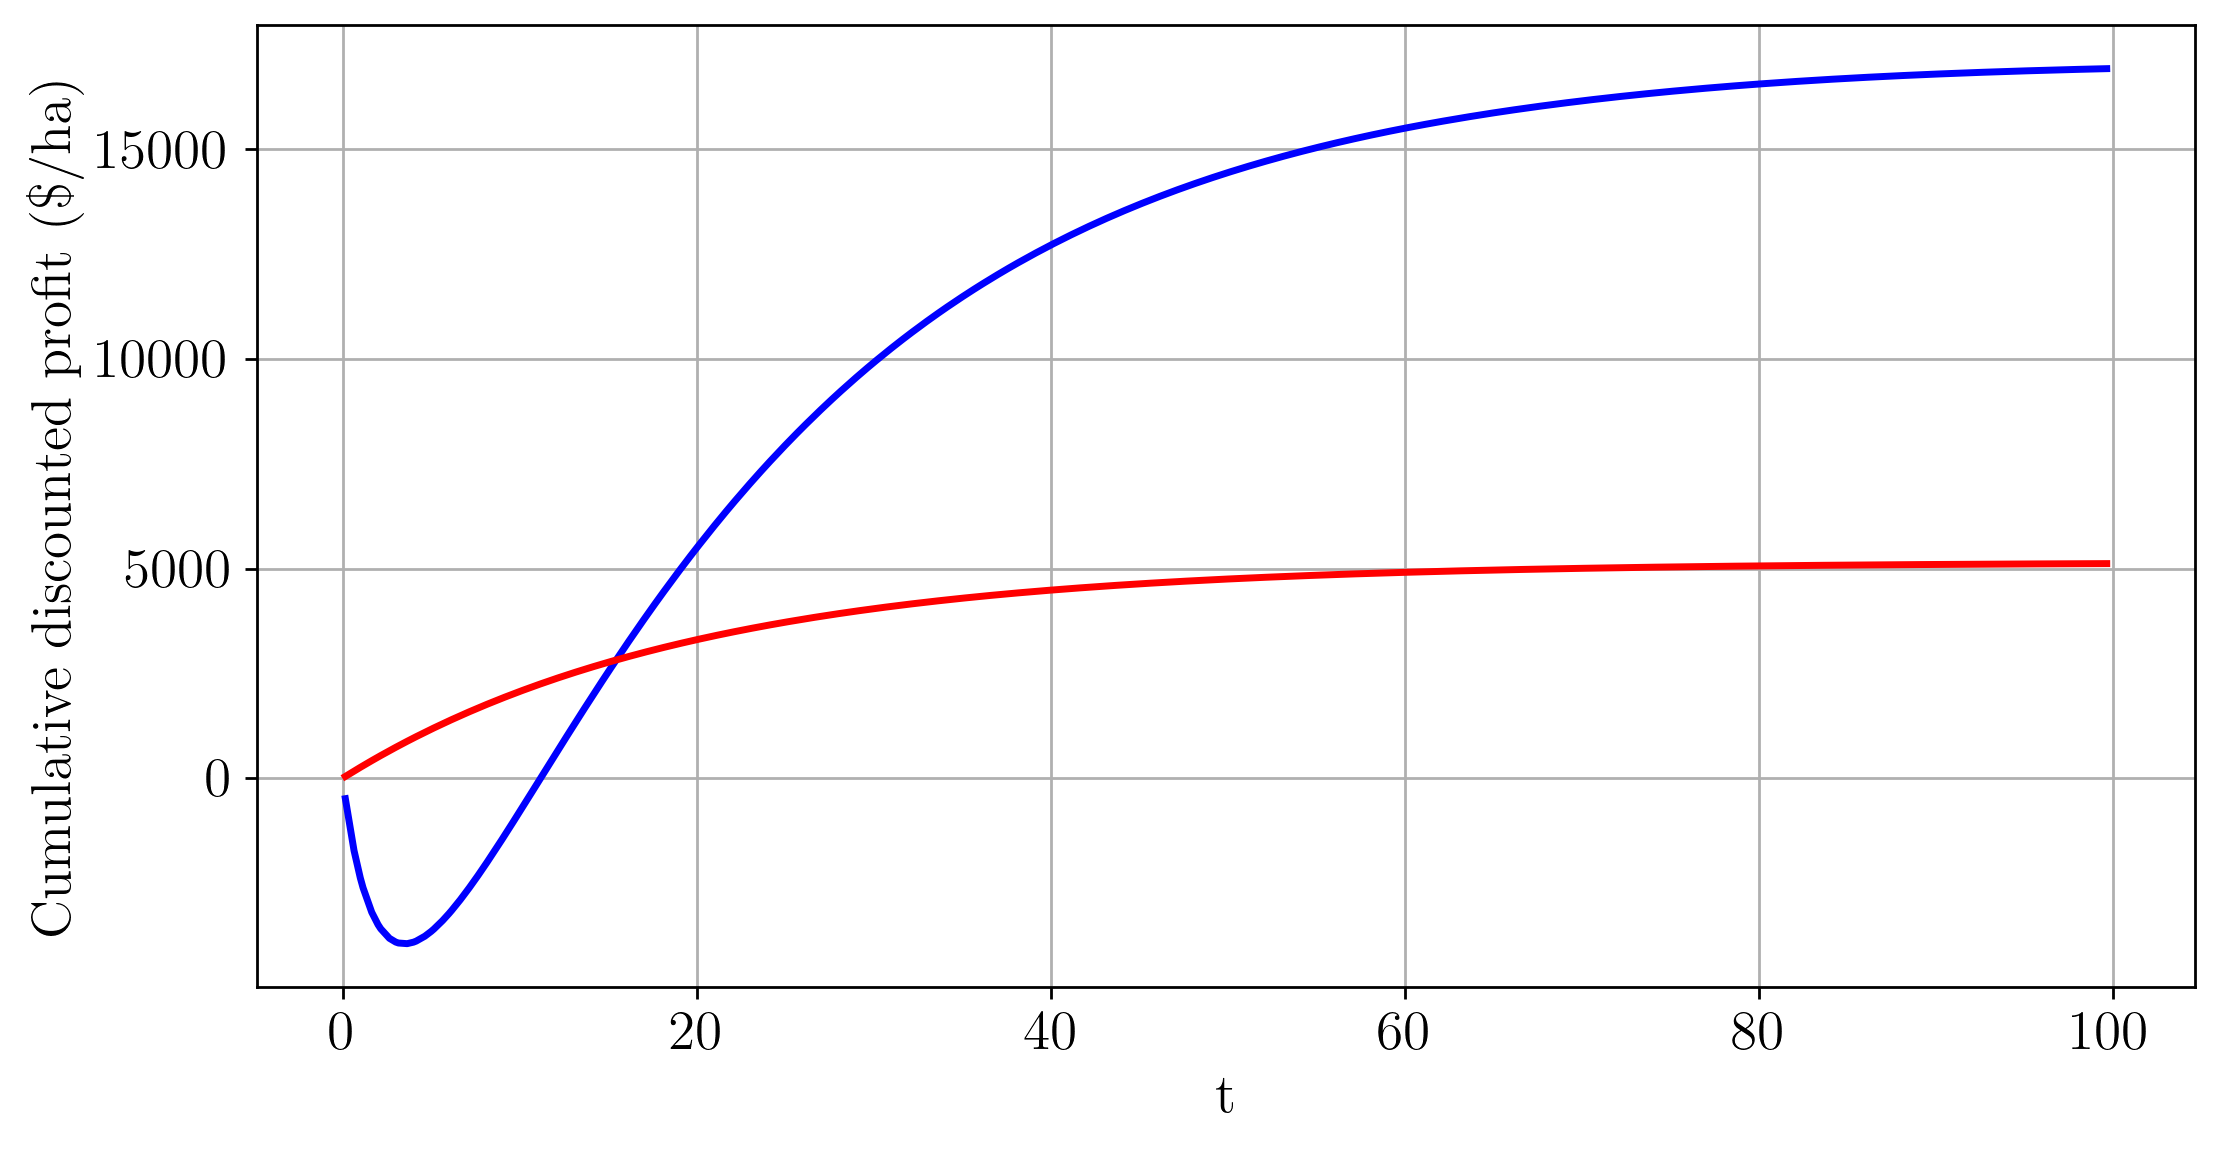

In [9]:
plt.figure(figsize=(10, 5), dpi=250)
plt.plot(t_opt[1:300], Z_opt[1:300], color = "blue", linewidth=2)
plt.plot(t_opt[1:300], Z_opt_additionality[1:300], color = "red", linewidth=2)
plt.xlabel(r"t")
plt.ylabel(r"Cumulative discounted profit (\$/ha)")
plt.grid(True)

In [10]:
# To present short-term policy analysis
# RUN
T_shown = 76
t_opt[1:T_shown] = [t + 2025 for t in t_opt[1:T_shown]]

print(t_opt[1:T_shown])

[2025.155051, 2025.644949, 2026.0, 2026.155051, 2026.644949, 2027.0, 2027.155051, 2027.644949, 2028.0, 2028.155051, 2028.644949, 2029.0, 2029.155051, 2029.644949, 2030.0, 2030.155051, 2030.644949, 2031.0, 2031.155051, 2031.644949, 2032.0, 2032.155051, 2032.644949, 2033.0, 2033.155051, 2033.644949, 2034.0, 2034.155051, 2034.644949, 2035.0, 2035.155051, 2035.644949, 2036.0, 2036.155051, 2036.644949, 2037.0, 2037.155051, 2037.644949, 2038.0, 2038.155051, 2038.644949, 2039.0, 2039.155051, 2039.644949, 2040.0, 2040.155051, 2040.644949, 2041.0, 2041.155051, 2041.644949, 2042.0, 2042.155051, 2042.644949, 2043.0, 2043.155051, 2043.644949, 2044.0, 2044.155051, 2044.644949, 2045.0, 2045.155051, 2045.644949, 2046.0, 2046.155051, 2046.644949, 2047.0, 2047.155051, 2047.644949, 2048.0, 2048.155051, 2048.644949, 2049.0, 2049.155051, 2049.644949, 2050.0]


SOC in 2030
[2030.0]
[28.45124512284258]
[40.50754082227969]
[12.05629569943711]
SOC in 2050
[2050.0]
[44.2455666312438]
[54.14582511807562]
[9.900258486831824]


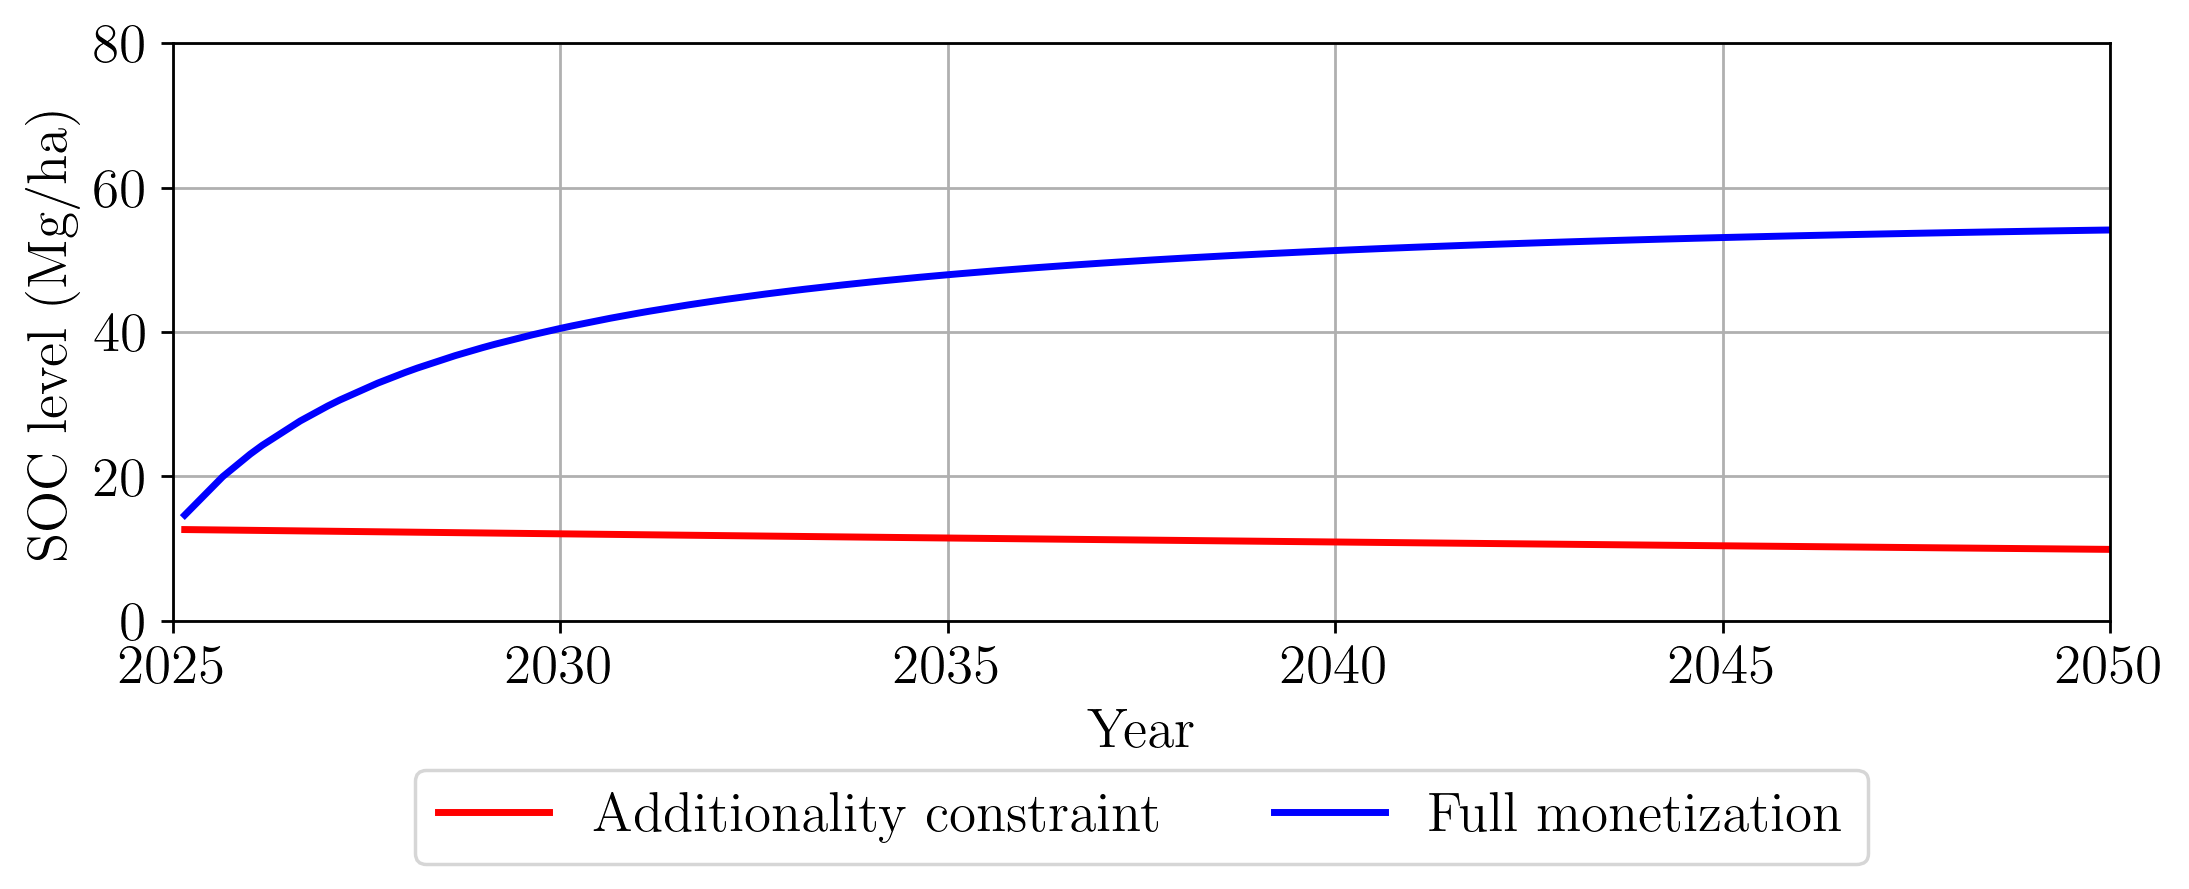

In [11]:
plt.figure(figsize=(10, 3), dpi=250)
plt.plot(t_opt[1:T_shown], C_opt_additionality[1:T_shown], label='Additionality constraint', color = "red", linewidth=2)
plt.plot(t_opt[1:T_shown], C_opt_full_monetization[1:T_shown], label='Full monetization', color = "blue", linewidth=2)
plt.xlabel(r"Year")
plt.ylabel(r"SOC level (Mg/ha)")
plt.ylim(0, 80)
plt.xlim(2025, 2050)
plt.xticks(range(2025, 2051, 5))
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=2)

print("SOC in 2030")
print(t_opt[15:16])
print(C_diff[15:16])
print(C_opt_full_monetization[15:16])
print(C_opt_additionality[15:16])

print("SOC in 2050")
print(t_opt[75:76])
print(C_diff[75:76])
print(C_opt_full_monetization[75:76])
print(C_opt_additionality[75:76])

# Robustness test

### Scenario 2
$C_0 = 1$, 
$\hat{C} = 6.16$, 
$\overline{C} = 9.08$

In [12]:
omega = 1

# Initial conditions
C0 = 1
hat_C = 6.16
overline_C = 9.08
theta = 1090 

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C0)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C0)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# compute results
C_opt_scenario2 = [M.C[t]() for t in M.t]
s_opt_scenario2 = [M.s[t]() for t in M.t]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

In [13]:
omega = 0.05

# Initial conditions
C0 = 1
hat_C = 6.16
overline_C = 9.08

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C0)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C0)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# compute results
C_opt_additionality_scenario2 = [M.C[t]() for t in M.t]
s_opt_additionality_scenario2 = [M.s[t]() for t in M.t]

C_diff_scenario2 = [x - y for x, y in zip(C_opt_scenario2, C_opt_additionality_scenario2)]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

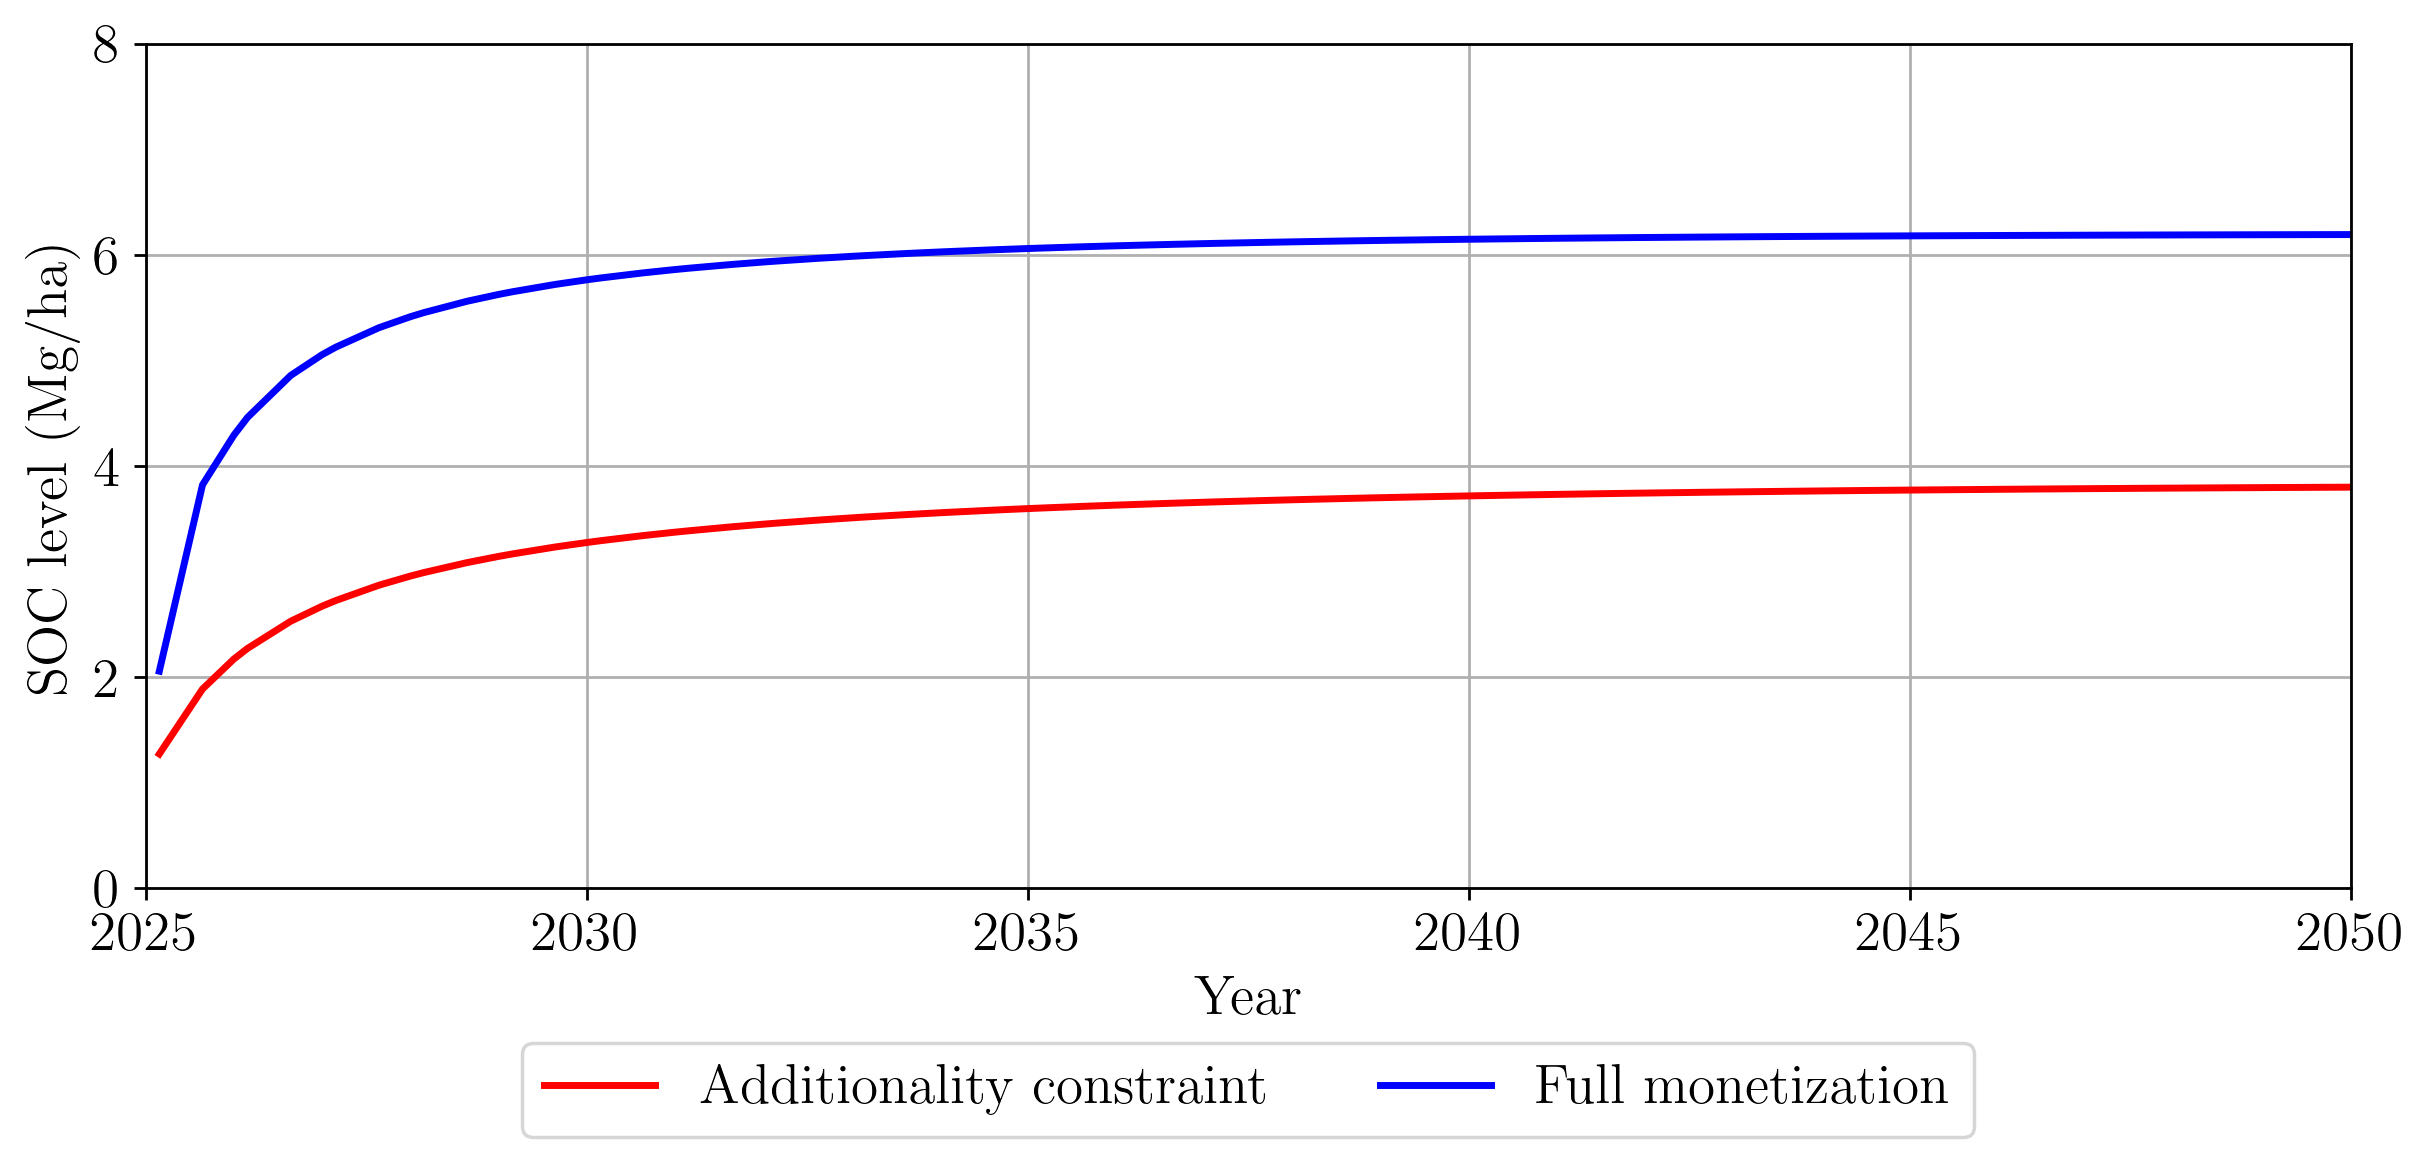

SOC in 2030
[2030.0]
[2.4884712588124365]
[5.765242030061439]
[3.276770771249003]
SOC in 2050
[2050.0]
[2.3928612213358127]
[6.1940907780897145]
[3.276770771249003]


In [14]:
plt.figure(figsize=(10, 5), dpi=250)
plt.plot(t_opt[1:T_shown], C_opt_additionality_scenario2[1:T_shown], label='Additionality constraint', color='red', linewidth=2)
plt.plot(t_opt[1:T_shown], C_opt_scenario2[1:T_shown], label='Full monetization', color='blue', linewidth=2)
plt.xlabel(r"Year")
plt.ylabel(r"SOC level (Mg/ha)")
plt.ylim(0, 8)
plt.xlim(2025, 2050)
plt.xticks(range(2025, 2051, 5))
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()

print("SOC in 2030")
print(t_opt[15:16])
print(C_diff_scenario2[15:16])
print(C_opt_scenario2[15:16])
print(C_opt_additionality_scenario2[15:16])

print("SOC in 2050")
print(t_opt[75:76])
print(C_diff_scenario2[75:76])
print(C_opt_scenario2[75:76])
print(C_opt_additionality_scenario2[15:16])

### Scenario 3
$C_0 = 1$, 
$\hat{C} = 6.16$, 
$\overline{C} = 7.62$

In [15]:
omega = 1

# Initial conditions
C0 = 1
hat_C = 6.16
overline_C = 7.62
theta = 905

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C0)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C0)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# compute results
C_opt_scenario3 = [M.C[t]() for t in M.t]
s_opt_scenario3 = [M.s[t]() for t in M.t]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

In [16]:
omega = 0.05

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C0)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C0)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# compute results
C_opt_additionality_scenario3 = [M.C[t]() for t in M.t]
s_opt_additionality_scenario3 = [M.s[t]() for t in M.t]

C_diff_scenario3 = [x - y for x, y in zip(C_opt_scenario3, C_opt_additionality_scenario3)]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

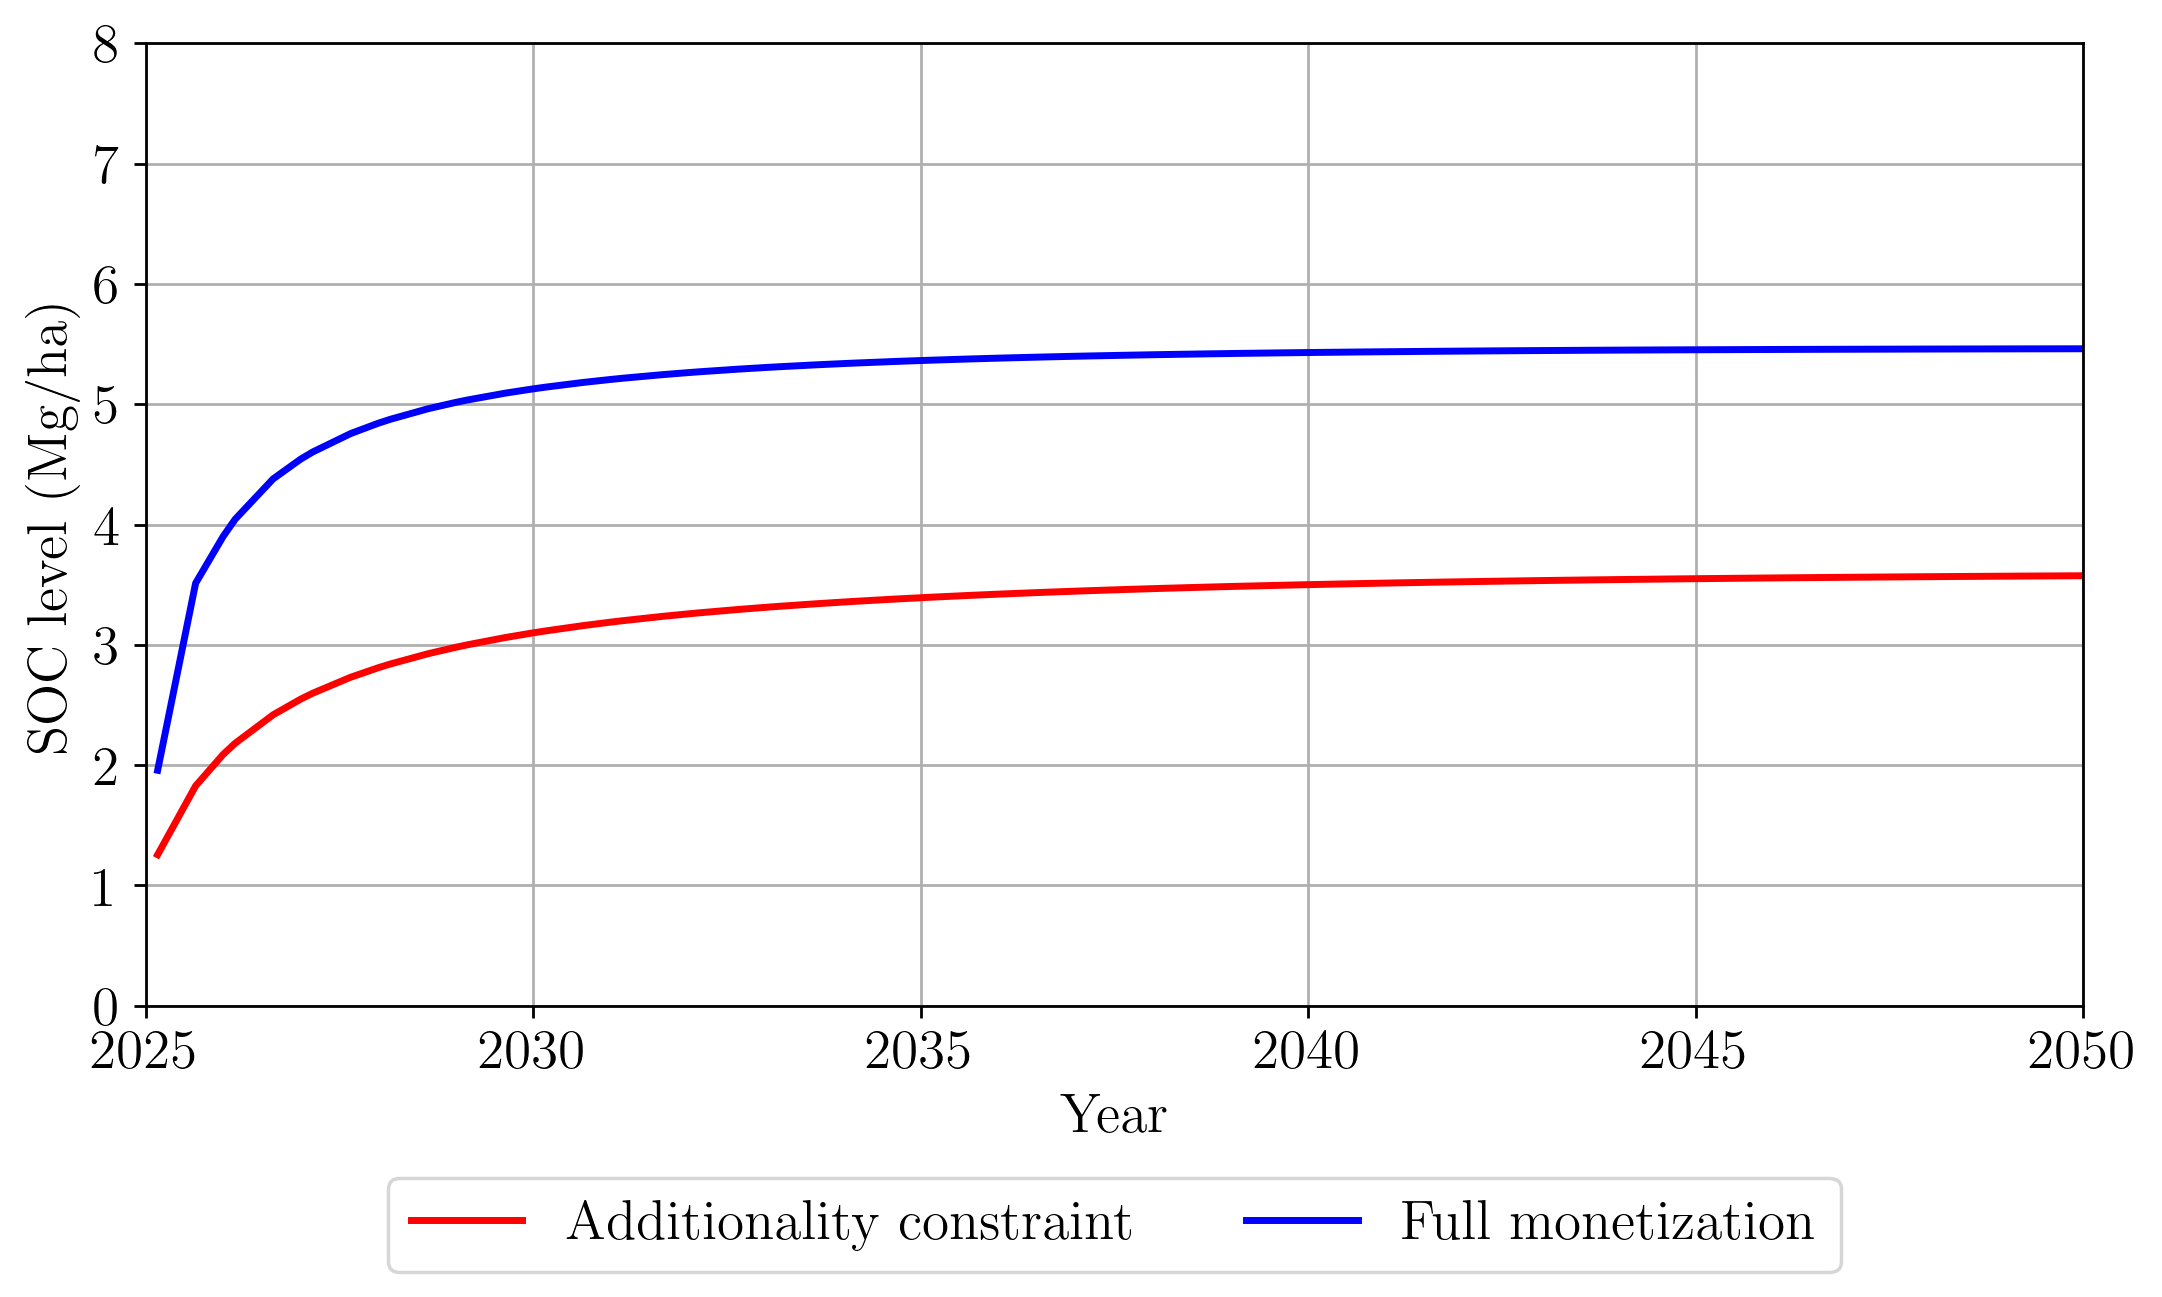

SOC in 2030
[2030.0]
[2.0280123523776394]
[5.127302682089902]
[3.0992903297122627]
SOC in 2050
[2050.0]
[1.8866058341886096]
[5.460733939287954]
[3.0992903297122627]


In [17]:
plt.figure(figsize=(10, 5), dpi=250)
plt.plot(t_opt[1:T_shown], C_opt_additionality_scenario3[1:T_shown], label='Additionality constraint', color='red', linewidth=2)
plt.plot(t_opt[1:T_shown], C_opt_scenario3[1:T_shown], label='Full monetization', color='blue', linewidth=2)
plt.xlabel(r"Year")
plt.ylabel(r"SOC level (Mg/ha)")
plt.ylim(0, 8)
plt.xlim(2025, 2050)
plt.xticks(range(2025, 2051, 5))
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

print("SOC in 2030")
print(t_opt[15:16])
print(C_diff_scenario3[15:16])
print(C_opt_scenario3[15:16])
print(C_opt_additionality_scenario3[15:16])

print("SOC in 2050")
print(t_opt[75:76])
print(C_diff_scenario3[75:76])
print(C_opt_scenario3[75:76])
print(C_opt_additionality_scenario3[15:16])

### Scenario 4
$C_0 = 1$, 
$\hat{C} = 6.16$, 
$\overline{C} = 10.54$

In [18]:
omega = 1

# Initial conditions
C0 = 1
hat_C = 6.16
overline_C = 10.54
theta = 1280

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C0)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C0)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# compute results
C_opt_scenario4 = [M.C[t]() for t in M.t]
s_opt_scenario4 = [M.s[t]() for t in M.t]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

In [19]:
omega = 0.05

# integrand of objective function
def obj_run(t, C, s, I):
    return pyo.exp(-rho * t) * (
        p_C * C * omega 
        + (kappa) * (1+gamma*(1-(C-hat_C)**2/((hat_C - C0)**2)))
        - s * theta * (overline_C - C)**(-eta) - I * FC
    )

# creating model
M = pyo.ConcreteModel()

# time horizon
M.t = dae.ContinuousSet(bounds=(0, T))

# states + derivatives
M.C = pyo.Var(M.t, bounds = (0, overline_C - 1e-3))
M.dC = dae.DerivativeVar(M.C, wrt = M.t)

# Mayer form conversion
M.Z = pyo.Var(M.t)
M.dZ = dae.DerivativeVar(M.Z, wrt = M.t)

# controls
M.s = pyo.Var(M.t, bounds = (0, 1000))

# Add a binary indicator variable: 1 if investment > 0, else 0
M.I = pyo.Var(M.t, domain=pyo.Binary)

# Big-M value for the max possible investment
big_M = 1000

# Link the indicator to the investment variable
def investment_indicator_rule(M, t):
    return M.s[t] <= big_M * M.I[t]
M.investment_indicator = pyo.Constraint(M.t, rule=investment_indicator_rule)

# constraints
M.ode_C = pyo.Constraint(M.t, rule = lambda M, t: M.dC[t] == ((M.s[t]**2 + epsilon)**(alpha / 2)) - delta * M.C[t])
M.ode_Z = pyo.Constraint(M.t, rule = lambda M, t: M.dZ[t] == obj_run(t, M.C[t], M.s[t], M.I[t]))

M.ode_C[M.t.first()].deactivate()
M.ode_Z[M.t.first()].deactivate()

# objective
M.obj = pyo.Objective(rule = lambda M: -M.Z[M.t.last()])

# initial values
M.C[M.t.first()].fix(C0)
M.Z[M.t.first()].fix(0)

# suffix for obtaining dual variables
M.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(M, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

# solve model
solver = pyo.SolverFactory('ipopt')
solver.options = {
    "max_iter": 10000,
}
results = solver.solve(M, tee=True)

# compute results
C_opt_additionality_scenario4 = [M.C[t]() for t in M.t]
s_opt_additionality_scenario4 = [M.s[t]() for t in M.t]

C_diff_scenario4 = [x - y for x, y in zip(C_opt_scenario4, C_opt_additionality_scenario4)]

Ipopt 3.11.1: max_iter=10000

==> Warning: Treating 301 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5094
Number of nonzeros in inequality constraint Jacobian.:      602
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     1802
                     variables with only 

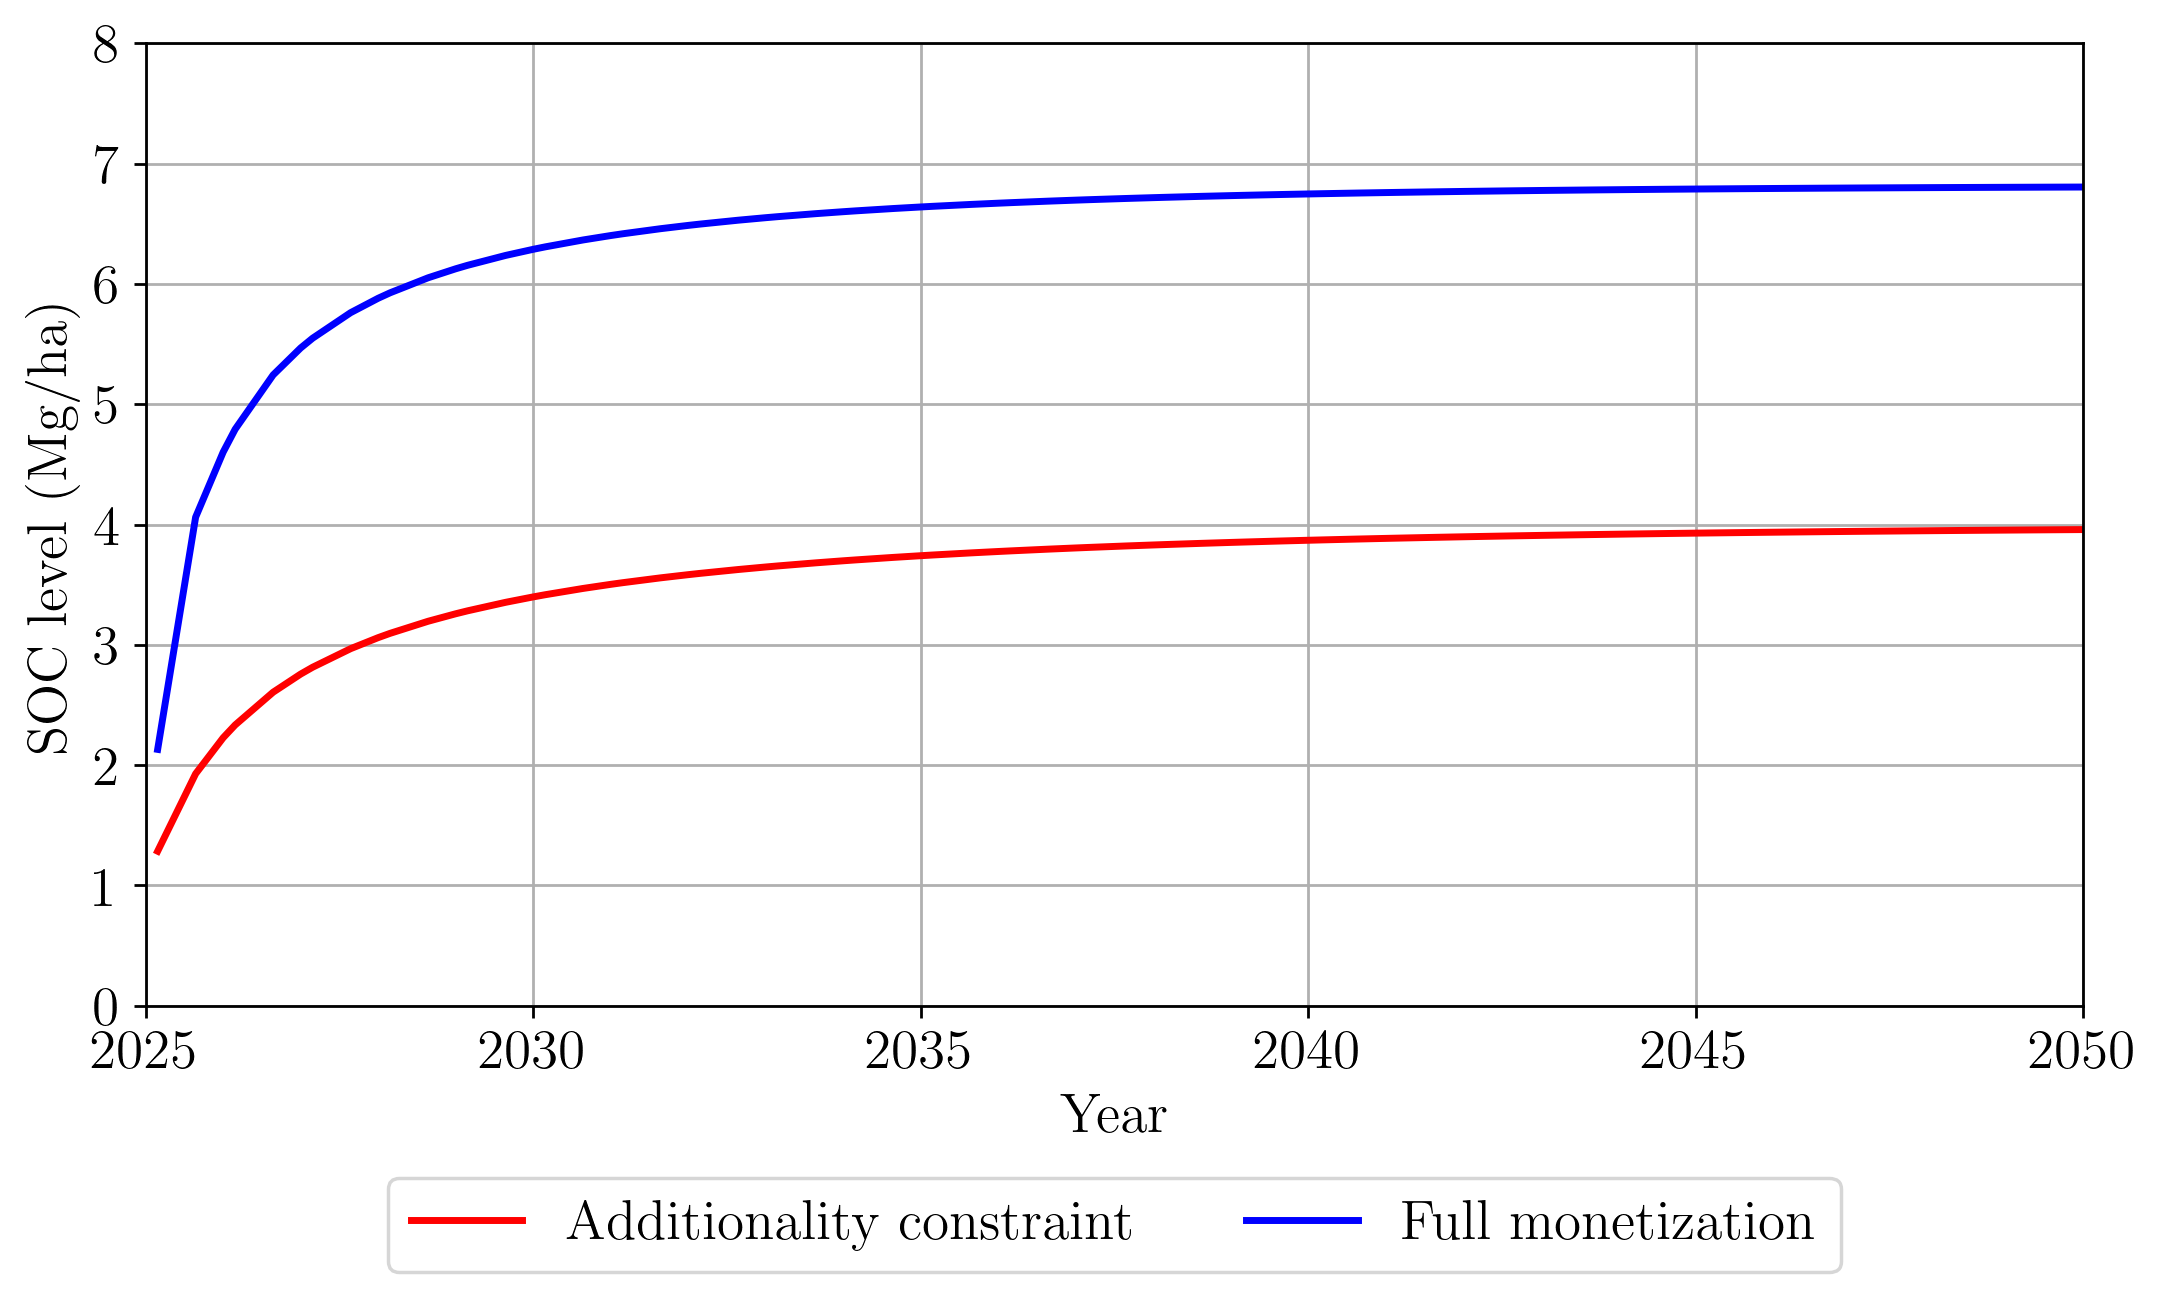

SOC in 2030
[2030.0]
[2.889123503297382]
[6.287188607164835]
[3.398065103867453]
SOC in 2050
[2050.0]
[2.8470490369817276]
[6.804909848417523]
[3.9578608114357956]


In [20]:
plt.figure(figsize=(10, 5), dpi=250)
plt.plot(t_opt[1:T_shown], C_opt_additionality_scenario4[1:T_shown], label='Additionality constraint', color='red', linewidth=2)
plt.plot(t_opt[1:T_shown], C_opt_scenario4[1:T_shown], label='Full monetization', color='blue', linewidth=2)
plt.xlabel(r"Year")
plt.ylabel(r"SOC level (Mg/ha)")
plt.ylim(0, 8)
plt.xlim(2025, 2050)
plt.xticks(range(2025, 2051, 5))
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

print("SOC in 2030")
print(t_opt[15:16])
print(C_diff_scenario4[15:16])
print(C_opt_scenario4[15:16])
print(C_opt_additionality_scenario4[15:16])

print("SOC in 2050")
print(t_opt[75:76])
print(C_diff_scenario4[75:76])
print(C_opt_scenario4[75:76])
print(C_opt_additionality_scenario4[75:76])